<a href="https://colab.research.google.com/github/Gooogr/Brain2Image/blob/master/sub_notebooks/PyTorch_DGAN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: <br>
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html<br>
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py<br>
https://github.com/nashory/gans-awesome-applications

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import torch

In [2]:
! nvidia-smi

Mon Sep 14 13:25:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED);

In [22]:
#DATAROOT = 
#THREADS = 
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 3 #number of color channels
NZ =  100 # length of latent vector
NGF = 64 # relates to the depth of feature maps carried through the generator
NDF = 64 # sets the depth of feature maps propagated through the discriminator
EPOCHS = 5
LR = 0.0002 #learning rate for training. As described in the DCGAN paper, this number should be 0.0002
BETA1 = 0.5 #beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
NGPU = 2

In [13]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

### Prepare dataset

In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
! ln -s "/content/drive/My Drive" "/content/mydrive"

Mounted at /content/drive


Download .zip archive

In [8]:
zip_path = '/content/mydrive/EEG2Image_research/Datasets/img_align_celeba.zip'
! mkdir /content/data
! unzip -qq $zip_path -d /content/data
print('Samples amount:')
!ls -l /content/data/img_align_celeba | wc -l

Samples amount:
202600


Create dataloader

In [9]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [10]:
dataset = dset.ImageFolder(root='/content/data',
                           transform=transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
import torchvision.utils as vutils

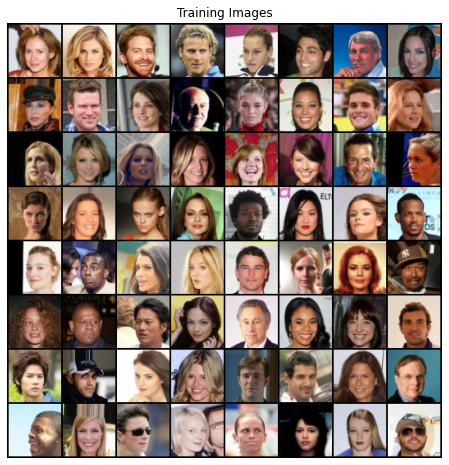

In [17]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Setting up model

Weight Initialization <br>

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.


In [23]:
import torch.nn as nn
import torch.nn.parallel

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator

In [24]:
class Generator(nn.Module):

    def __init__(self, ngpu):
        pass